In [1]:
%matplotlib inline
import torch
import torch.nn.functional as F
import json
import numpy as np
from espnet.utils.io_utils import LoadInputsAndTargets
from espnet.utils.training.batchfy import make_batchset
from espnet.asr.pytorch_backend.asr_init import load_trained_model
from espnet.asr.pytorch_backend.asr import CustomConverter
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")

In [3]:
with open("/root/kws_data/dump/train/deltafalse/data.json", "r") as f:
    data_json = json.load(f)["utts"]

In [4]:
data_batches = make_batchset(data_json, 1)

In [5]:
load_tr = LoadInputsAndTargets(
        mode='asr', load_output=True, preprocess_conf=None,
        preprocess_args={'train': True}  # Switch the mode of preprocessing
    )

In [6]:
model, train_args = load_trained_model("/shreekanth2/train_clean_100_pytorch_phone_hybrid/results/model.acc.best")
model = model.to(device=device)
model.dec.sampling_probability = 0

/root/espnet/tools/venv/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [7]:
converter = CustomConverter(subsampling_factor=1, dtype=torch.float32)

In [8]:
data_batches[1000]

[('c673bc5e-859b-4d4d-ab86-ff4d7a9c9737',
  {'input': [{'feat': '/root/kws_data/dump/train/deltafalse//feats.25.ark:41105713',
     'name': 'input1',
     'shape': [741, 80]}],
   'output': [{'name': 'target1',
     'shape': [1, 5],
     'text': '0',
     'token': '0',
     'tokenid': '2'}],
   'utt2spk': 'c673bc5e-859b-4d4d-ab86-ff4d7a9c9737'})]

In [9]:
data_batches[-200]

[('38e81e02-72a7-46b5-b551-134e00df66b3',
  {'input': [{'feat': '/root/kws_data/dump/train/deltafalse//feats.8.ark:5891195',
     'name': 'input1',
     'shape': [128, 80]}],
   'output': [{'name': 'target1',
     'shape': [1, 5],
     'text': '1',
     'token': '1',
     'tokenid': '3'}],
   'utt2spk': '38e81e02-72a7-46b5-b551-134e00df66b3'})]

In [10]:
phone_to_int = dict(zip(train_args.char_list, np.arange(len(train_args.char_list))))

In [11]:
keyword = "<space> HH EY <space> S N IH P S <space>"

In [12]:
keyword_tokens = torch.tensor([[phone_to_int[phn] for phn in keyword.split(" ")]]).to(device)

In [13]:
keyword_tokens

tensor([[ 2, 18, 15,  2, 31, 25, 19, 29, 31,  2]])

In [14]:
neg_data_input = [load_tr(data_batches[1000])]
pos_data_input = [load_tr(data_batches[-200])]

In [15]:
neg_data = converter(neg_data_input, device)
pos_data = converter(pos_data_input, device)

In [16]:
neg_hs_pad, neg_hlens, _ = model.enc(neg_data[0], neg_data[1])
pos_hs_pad, pos_hlens, _ = model.enc(pos_data[0], pos_data[1])

In [17]:
att_loss, acc, ppl, neg_att_w_list = model.dec(neg_hs_pad, neg_hlens, keyword_tokens)

In [18]:
att_loss, acc, ppl, pos_att_w_list = model.dec(pos_hs_pad, pos_hlens, keyword_tokens)

In [19]:
def get_att_plot(att_w_list):
    atts = [ele.detach().cpu().numpy().flatten() for ele in att_w_list]
    atts = np.array(atts)
    sum_att = np.prod(atts, axis=0)
    return sum_att

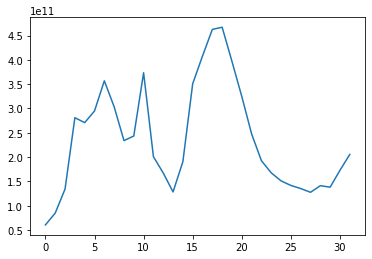

In [27]:
plt.plot(get_att_plot(pos_att_w_list))

In [35]:
np.mean(get_att_plot(pos_att_w_list))

236092950000.0

In [34]:
np.mean(get_att_plot(neg_att_w_list))

42186410000.0

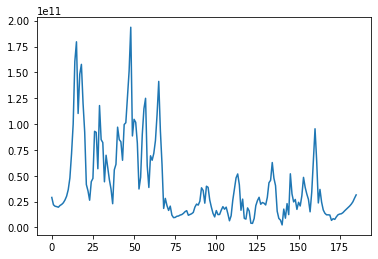

In [30]:
plt.plot(get_att_plot(neg_att_w_list))

In [ ]:
# plt.plot(get_att_plot(neg_att_w_list))
# np.trapz(get_att_plot(pos_att_w_list), dx=1)
# np.trapz(get_att_plot(neg_att_w_list), dx=1)

In [39]:
def get_att_score(att_w_list):
    atts = [ele.detach().cpu().numpy().flatten() for ele in att_w_list]
    atts = np.array(atts)
    init_att = atts[0]
    for att in atts[1:]:
        init_att = np.abs(init_att - att)
    att_score = np.mean(init_att)
    return init_att, att_score

7.7538614


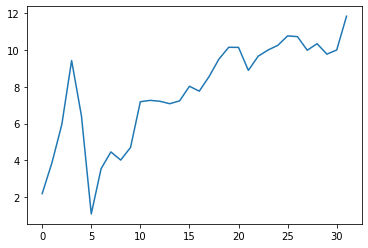

In [40]:
att, score = get_att_score(pos_att_w_list)
plt.plot(att)
print(score)

5.0949388


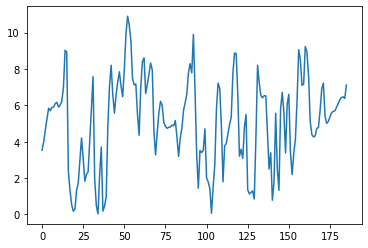

In [41]:
att, score = get_att_score(neg_att_w_list)
plt.plot(att)
print(score)